In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
import random
import pickle
from sklearn.preprocessing import StandardScaler
import os
import tensorflow as tf
from tqdm.notebook import tqdm
from scipy.stats import multivariate_normal as mvn
import matplotlib.pyplot as plt
from joblib import Parallel, delayed

2023-06-09 18:16:00.453438: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-09 18:16:00.455778: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 18:16:00.493670: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-06-09 18:16:00.494462: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-09 18:16:02.262370: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [3]:
def get_targets_with_weights(batch_data, batch_data1, initial_ensembles, size_ens): 

    weights_ann_1 = ann_15.get_weights()
    weights_ann_2 = ann_20.get_weights()
    
    n_hidden_1 = len(weights_ann_1[0].ravel())
    
    hidden_weights_1 = initial_ensembles[:,:n_hidden_1].reshape( size_ens, batch_data.shape[1], h1)
    
    
    hidden_output_1 = np.einsum('ij,kjl->kil', batch_data, hidden_weights_1)

    
    hidden_layer_bias_1 = initial_ensembles[:,n_hidden_1:(n_hidden_1 + h1)].reshape(size_ens, 1,  h1)


    hidden_output_1 = hidden_output_1 + hidden_layer_bias_1

    n_pred_weights_1 = len(weights_ann_1[2].ravel())

    output_weights_1 = initial_ensembles[:,(n_hidden_1 + h1):(n_hidden_1 + h1 + n_pred_weights_1) ].reshape(size_ens, h1, target_dim)


    output_1 = np.einsum('ijk,ikl->ijl', hidden_output_1, output_weights_1)


    output_layer_bias_1 = initial_ensembles[:,(n_hidden_1 + h1 + n_pred_weights_1):(n_hidden_1 + h1 + n_pred_weights_1 + target_dim)].reshape(size_ens, 1, target_dim)


    final_output_1 = output_1 + output_layer_bias_1



    n_hidden_2 = len(weights_ann_2[0].ravel())

    initial_ensembles_1 = initial_ensembles.copy()[:, total_weights_1:(total_weights_1+ total_weights_2)]

    hidden_weights_2 = initial_ensembles_1[:,:n_hidden_2].reshape(size_ens, batch_data1.shape[1], h2)



    hidden_output_2 = np.einsum('ij,kjl->kil', batch_data1, hidden_weights_2)

    hidden_layer_bias_2 = initial_ensembles_1[:,n_hidden_2:(n_hidden_2 + h2)].reshape(size_ens, 1,  h2)


    # hidden_layer_bias_2 = np.expand_dims(hidden_layer_bias_2, 0)

    hidden_output_2 = hidden_output_2+ hidden_layer_bias_2
#     hidden_layer_bias_2 = hidden_layer_bias_2 + hidden_layer_bias_2


    n_pred_weights_2 = len(weights_ann_2[2].ravel())

    output_weights_2 = initial_ensembles_1[:,(n_hidden_2 + h2):(n_hidden_2 + h2 + n_pred_weights_2) ].reshape(size_ens, h2, target_dim)


    output_2 = np.einsum('ijk,ikl->ijl', hidden_output_2, output_weights_2)


    output_layer_bias_2 = initial_ensembles_1[:,(n_hidden_2 + h2 + n_pred_weights_2):(n_hidden_2 + h2 + n_pred_weights_2 + target_dim)].reshape(size_ens, 1, target_dim)

    # output_layer_bias_2 = np.expand_dims(output_layer_bias_2, 0)


    final_output_2 = output_2 + output_layer_bias_2


    weights_1 = initial_ensembles[:, :total_weights_1]

    weights_2 = initial_ensembles[:, total_weights_1:(total_weights_1 + total_weights_2)]

#     print(weights_1.shape)
    
    # print(weights_2.shape)

    avg_weights = initial_ensembles[:, -7].reshape(-1,1)
    
    # cov_matrix_parms =  initial_ensembles[:, -3:].reshape(-1,1)
    
    # avg_weights_not_sig = avg_weights.reshape(avg_weights.shape[0], 1, avg_weights.shape[1])
    
    
    avg_weights_sig = expit(avg_weights)
    
    avg_weights_sig = avg_weights_sig.reshape(avg_weights_sig.shape[0], 1, avg_weights_sig.shape[1])
    
    
    complement_weights_sig = 1 - expit(avg_weights)
    
    complement_weights_sig = complement_weights_sig.reshape(complement_weights_sig.shape[0], 1, complement_weights_sig.shape[1])
    

    final_output_1 = final_output_1*complement_weights_sig
    
    final_output_2 = final_output_2*avg_weights_sig
    
    return final_output_1 + final_output_2

In [4]:
def ann(hidden = 32, input_shape = 256, output_shape = 2): 
    input_layer = tf.keras.layers.Input(shape = (input_shape))
    hidden_layer = tf.keras.layers.Dense(hidden)
    hidden_output = hidden_layer(input_layer)
    pred_layer = tf.keras.layers.Dense(output_shape, activation = "relu")
    pred_output = pred_layer(hidden_output)
#     pred_output = tf.keras.layers.Activation("softmax")(pred_output)
    model = tf.keras.models.Model(input_layer, pred_output)
    return model

In [5]:
def expit(x):
    """Compute softmax values for each sets of scores in x."""
#     e_x = np.exp(x - np.max(x))
    return 1 / (1 + np.exp(-x))

In [6]:
alogp_bottleneck = np.load("..//Data/small_mol_phase_3_features_for_both.npy")

In [7]:
# y_valid

In [8]:
y_valid = pd.read_csv("..//Data/smiles_with_rdkit_with_small_phase_3_outputs.csv")

In [9]:
# y_valid

In [10]:
std_targets = pickle.load( open('..//Data//target_scaler.pkl', 'rb'))

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:318: UserWarning: Trying to unpickle estimator StandardScaler from version 1.1.2 when using version 1.2.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [11]:
# y_valid

In [12]:
y_train = y_valid.values[:,1:]

In [13]:
y_train = std_targets.transform(y_train)

/home/statgrads/vpiyush2/.conda/envs/enkf/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


In [14]:
# R_t = np.cov(y_train.T)

In [15]:
from sklearn.model_selection import train_test_split

In [16]:
x_train, x_valid, y_train, y_valid = train_test_split(alogp_bottleneck, y_train, test_size = 0.25, shuffle = True, 
                                                     random_state = 42)

In [17]:
x_train.shape

(719, 64)

In [18]:
from scipy.linalg import block_diag

In [19]:
x_valid.shape

(240, 64)

In [20]:
y_train.shape, y_valid.shape

((719, 2), (240, 2))

In [21]:
# n = x_train.shape[0]
# R_t = block_diag(*([R_t] * n))

In [22]:
# R_t.shape

In [23]:
smiles_feats_train = x_train[:, :32]

In [24]:
rdkit_feats_train = x_train[:, 32:]

In [25]:
smiles_feats_valid = x_valid[:, :32]
rdkit_feats_valid = x_valid[:, 32:]

In [26]:
h1, h2 = 16, 16

In [27]:
ann_15 = ann(h1, 32, 2)

2023-06-09 18:16:05.103621: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2023-06-09 18:16:05.103673: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:168] retrieving CUDA diagnostic information for host: c3101.swan.hcc.unl.edu
2023-06-09 18:16:05.103686: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:175] hostname: c3101.swan.hcc.unl.edu
2023-06-09 18:16:05.103835: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:199] libcuda reported version is: 525.85.5
2023-06-09 18:16:05.103865: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:203] kernel reported version is: 525.85.5
2023-06-09 18:16:05.103876: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:309] kernel version seems to match DSO: 525.85.5


In [28]:
ann_20 = ann(h2, 32, 2)

In [29]:
total_weights_1 = ann_15.count_params()

In [30]:
total_weights_2 = ann_20.count_params()

In [31]:
total_weights = total_weights_1 + total_weights_2 + 1 + 4 + 2

In [32]:
total_weights

1131

In [33]:
# generate MVN from 0 and some var
initial_ensembles_mean = np.zeros((total_weights,))

In [34]:
lambda1 = 1

In [35]:
initial_ensembles_cov = lambda1*np.identity(total_weights)

In [36]:
reduction = 4

In [37]:
size_ens = total_weights//reduction

In [38]:
initial_ensembles = mvn(initial_ensembles_mean, initial_ensembles_cov).rvs(size_ens)

In [39]:
initial_ensembles.shape

(282, 1131)

In [40]:
# cov_mat_final

In [41]:
def is_pos_def(x):
    return np.all(np.linalg.eigvals(x) > 0)

In [42]:
# is_pos_def(cov_mat_final)

In [43]:
def create_cov(shape, initial_ensembles):
    cov_part = initial_ensembles[:, -6:-2]
    cov_part = cov_part.mean(0)
    # variances = tf.math.softplus(cov_part[:2]).numpy()
    variances = cov_part[:2]
    covariances = cov_part[2:]
    base_cov = np.identity(target_dim)
    base_cov[0,0] = variances[0]
    base_cov[1,1] = variances[1]
    base_cov[0,1] = covariances[0]
    base_cov[1,0] = covariances[1]
    
    variances1 = tf.math.softplus(initial_ensembles[:, -2:]).numpy()
    variances1 = variances1.mean(0)
    base_variances = np.identity(target_dim)
    base_variances[0,0] = variances1[0]
    base_variances[1,1] = variances1[1]
    
    final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
    cov_mat = final@final.T
    cov_mat_final = cov_mat
    # cov_mat_final = cov_mat@cov_mat.T
    
    if is_pos_def(cov_mat_final) != True:
        print("resulting cov matrix is not positive semi definite")
        pass
    
    # print(np.linalg.det(cov_mat_final))
    
    n = shape
    R_t = block_diag(*([cov_mat_final] * n))
    
    lambda_inv = np.linalg.inv(R_t)
    
    return lambda_inv
    

In [44]:
# create_cov(smiles_feats_train.shape[0], initial_ensembles)

In [45]:
# np.linalg.det(np.array(all_covs))

In [46]:
# tf.math.softplus(-0.2043372)

In [47]:
# initial_ensembles[:, -3:-1]

In [48]:
# all_covs = np.array(all_covs)

In [49]:
# all_covs.shape

In [50]:
def calculate_mu_bar_G_bar(data1, data2, initial_ensembles):
    mu_bar = initial_ensembles.mean(0)
    G_u = get_targets_with_weights(data1, data2, initial_ensembles, size_ens = size_ens)
    G_u = G_u.reshape(G_u.shape[0], G_u.shape[1]*G_u.shape[2])
    G_bar = (G_u.mean(0)).ravel()
    return mu_bar.reshape(-1,1), G_bar.reshape(-1,1), G_u

In [51]:
def calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u): 
    u_j_minus_u_bar = initial_ensembles - mu_bar.reshape(1,-1)
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    c = np.zeros((total_weights, G_bar.shape[0]))
    for i in range(0, size_ens): 
        c += np.kron(u_j_minus_u_bar[i, :].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return c/size_ens, G_u_minus_G_bar

In [52]:
def calculate_D_u( G_bar, G_u): 
    G_u_minus_G_bar = G_u -  G_bar.reshape(1,-1)
    d = np.zeros((G_bar.shape[0], G_bar.shape[0]))
    for i in range(0, size_ens): 
        d += np.kron(G_u_minus_G_bar[i,:].T.reshape(-1,1), G_u_minus_G_bar[i,:].reshape(-1,1).T)
    return d/size_ens

In [53]:
def get_updated_ensemble(data1, data2, initial_ensembles):
    mu_bar, G_bar, G_u = calculate_mu_bar_G_bar(data1, data2, initial_ensembles)
    C, G_u_minus_G_bar = calculate_C_u(initial_ensembles, mu_bar, G_bar, G_u)
    D = calculate_D_u( G_bar, G_u)
    all_covs = create_cov(data1.shape[0],initial_ensembles)
    # all_covs = np.array(all_covs)
    D_plus_cov = (D + all_covs)
    D_plus_cov_inv = np.linalg.inv(D_plus_cov)
    mid_quant = C@D_plus_cov_inv
    # mid_quant = C@np.linalg.inv(D + lambda_inv)
    right_quant = y_train.ravel().reshape(-1,1) - G_u.T
    mid_times_right = mid_quant@right_quant
    updated_ensemble = (initial_ensembles.T + mid_times_right)
    # updated_ensemble = updated_ensemble.mean(0)
    return updated_ensemble.T

In [54]:
target_dim = 2

In [55]:
lambda_D = 1

In [56]:
u_bar, G_bar, G_u = calculate_mu_bar_G_bar(smiles_feats_train, rdkit_feats_train, initial_ensembles)

In [57]:
G_bar.shape

(1438, 1)

In [58]:
def inverse_transform(data, idx):
    data_cur = data[idx, :, :]
    inv_data_cur = std_targets.inverse_transform(data_cur)
    return inv_data_cur

In [59]:
# catch = Parallel(n_jobs = 15, verbose = 3)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))

In [60]:
for i in range(0,10000):
    
    initial_ensembles = get_updated_ensemble(smiles_feats_train, rdkit_feats_train, initial_ensembles)
    
    G_u_train = get_targets_with_weights(smiles_feats_train, rdkit_feats_train, initial_ensembles, size_ens = size_ens)
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_train, i)  for i in range(G_u_train.shape[0]))
    G_u_train = np.array(catch)
    
    y_train_cur = std_targets.inverse_transform(y_train)
    
    li_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_train = np.percentile(G_u_train, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_train = ui_train - li_train
    avg_width_train = width_train.mean(0)
    
    ind_train = (y_train_cur >= li_train) & (y_train_cur <= ui_train)
    coverage_train= ind_train.mean(0)
    
    averaged_targets_train = G_u_train.mean(0)
    rmse_train = np.sqrt(((y_train_cur -averaged_targets_train)**2).mean(0))
    print(rmse_train, coverage_train, avg_width_train)
    
    G_u_test = get_targets_with_weights(smiles_feats_valid, rdkit_feats_valid, initial_ensembles, size_ens = size_ens)
    
    catch = Parallel(n_jobs = 15, verbose = 0)(delayed(inverse_transform)(G_u_test, i)  for i in range(G_u_test.shape[0]))
    G_u_test = np.array(catch)
    
    y_valid_cur = std_targets.inverse_transform(y_valid)    
    
    li_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[0,:,:]   
    ui_test = np.percentile(G_u_test, axis = 0, q = (2.5, 97.5))[1,:,:]
    
    width_test = ui_test - li_test
    avg_width_test = width_test.mean(0)
    
    ind_test = (y_valid_cur >= li_test) & (y_valid_cur <= ui_test)
    coverage_test= ind_test.mean(0)
    
    averaged_targets_test = G_u_test.mean(0)
    rmse_test = np.sqrt(((y_valid_cur -averaged_targets_test)**2).mean(0))    
    
    # plt.scatter(y_valid[:, 0], averaged_targets_test[:,0])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    # plt.scatter(y_valid[:,1], averaged_targets_test[:, 1])
    # plt.axline((0,0), slope = 1, c= "black")
    # plt.show()
    
    avg_weights = initial_ensembles[:, -7].reshape(-1,1)
    
    # print(avg_weights.mean(), avg_weights.std())
    
    
    if coverage_train.mean() < 0.95:
        break
    
    print(rmse_test, coverage_test, avg_width_test)
    
    print(expit(avg_weights).mean(), expit(avg_weights).std())

[ 3.12839044 78.54382898] [1. 1.] [ 101.62203586 2373.29103412]
[ 2.79220869 70.05625545] [1. 1.] [ 100.37968892 2327.28897299]
0.4575284397028065 0.18273157365514517
[ 2.24431    51.33590649] [1. 1.] [  76.52372107 1805.45221041]
[ 2.21720991 45.65990288] [1. 1.] [  76.04081188 1783.40196817]
0.43313827127491755 0.16450485560260253
[ 2.38894527 58.52004265] [1. 1.] [  63.12737806 1501.08025431]
[ 2.37868692 51.91946072] [1. 1.] [  61.98478579 1481.52910751]
0.42149243427878513 0.1526900293492157
[ 2.36169797 55.12348653] [1. 1.] [  58.44288785 1396.1466285 ]
[ 2.39695151 49.54829376] [1. 1.] [  58.29591897 1379.03394424]
0.4228912893518376 0.14551642546305557
[ 1.73481635 57.47144309] [1. 1.] [  52.1861551  1232.59894732]
[ 1.73064825 51.35635207] [1. 1.] [  51.65643569 1219.58367835]
0.4197466724472272 0.1407722249811491
[ 1.94739628 56.79006256] [1. 1.] [  46.95613189 1133.90494333]
[ 1.99044991 51.0868677 ] [1. 1.] [  46.47898378 1125.67216247]
0.4114250786271972 0.1369583782331486


KeyboardInterrupt



In [61]:
G_u_test.shape

(282, 240, 2)

In [62]:
import random

In [63]:
random_idx = random.sample(range(y_valid_cur.shape[0]), k = 8)

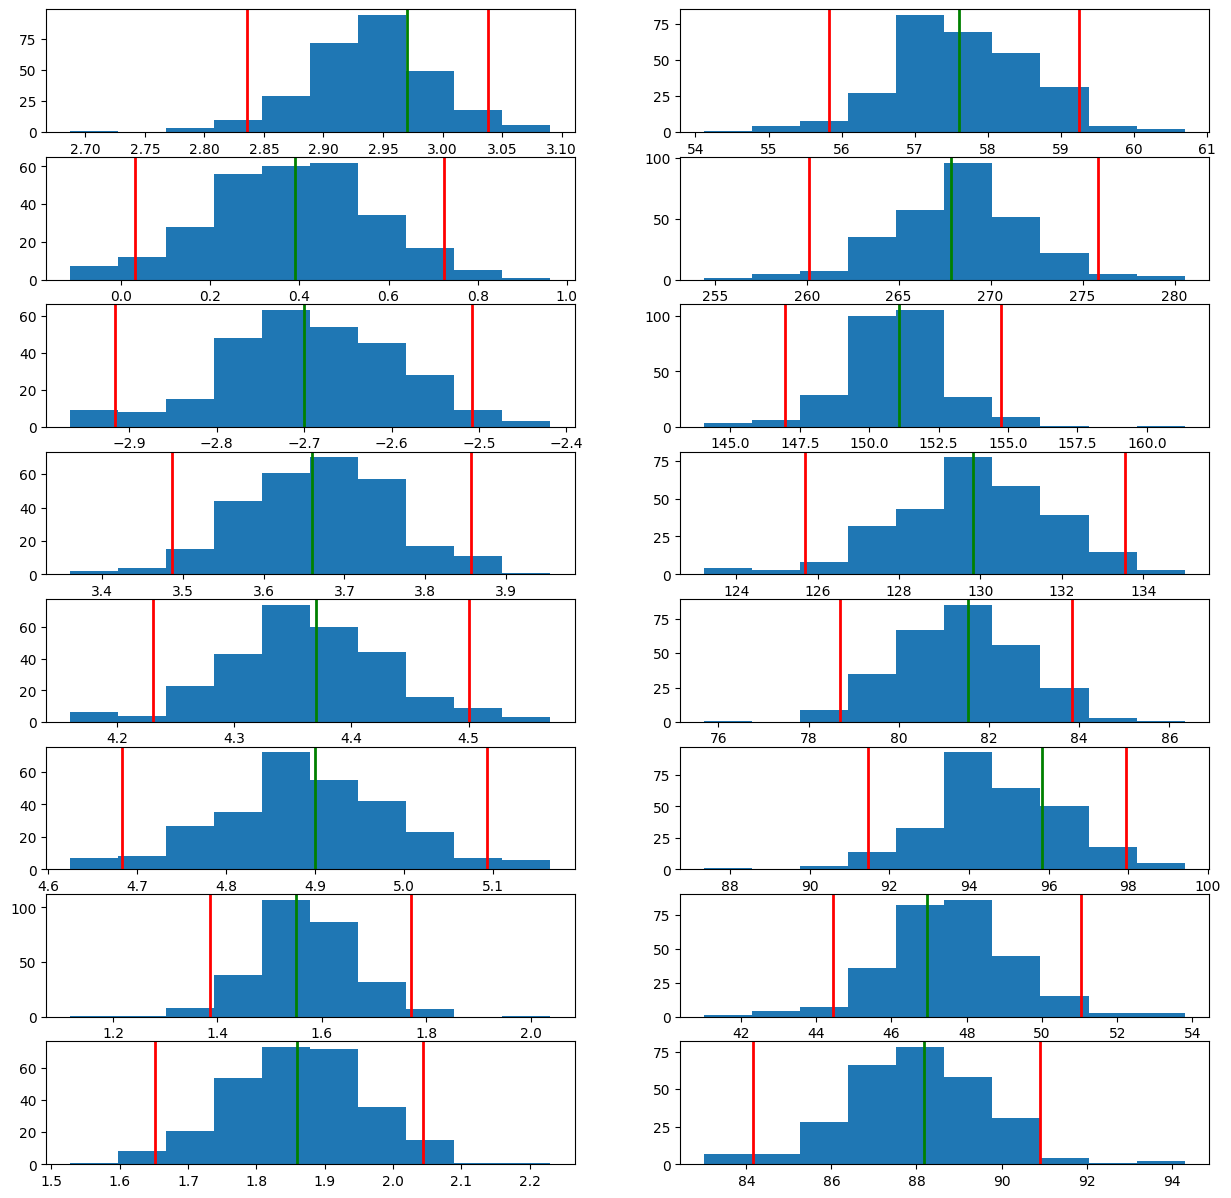

In [64]:
fig, axs = plt.subplots(8, 2,figsize=(15, 15))
# axs = axs.ravel()
# counter = 0
for idx, i in enumerate(random_idx):
    # print(counter)
    truth = y_valid_cur[i,:]
    preds = G_u_test[:, i,:]
    percts = np.percentile(preds, axis = 0, q = (2.5, 97.5))
    lis = percts[0,:]
    uis = percts[1,:]
    
    
    axs[idx, 0].hist(preds[:,0])
    axs[idx, 0].axvline(truth[0], color='green', linewidth=2)
    axs[idx, 0].axvline(lis[0], color='red', linewidth=2)
    axs[idx, 0].axvline(uis[0], color='red', linewidth=2)
    
    axs[idx, 1].hist(preds[:,1])
    axs[idx, 1].axvline(truth[1], color='green', linewidth=2)
    axs[idx, 1].axvline(lis[1], color='red', linewidth=2)
    axs[idx, 1].axvline(uis[1], color='red', linewidth=2)
    
    # counter+=2
    # print(counter)
    
    # plt.show()
plt.savefig('prediction_intervals.png', bbox_inches='tight')

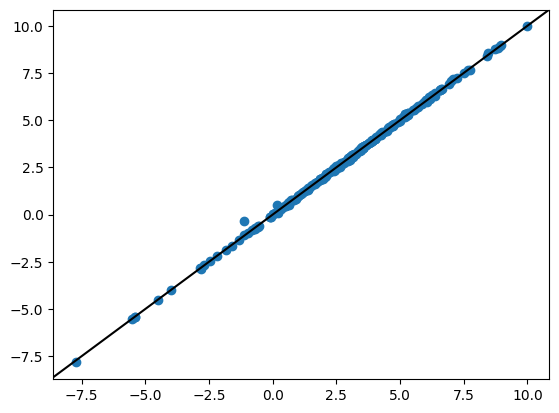

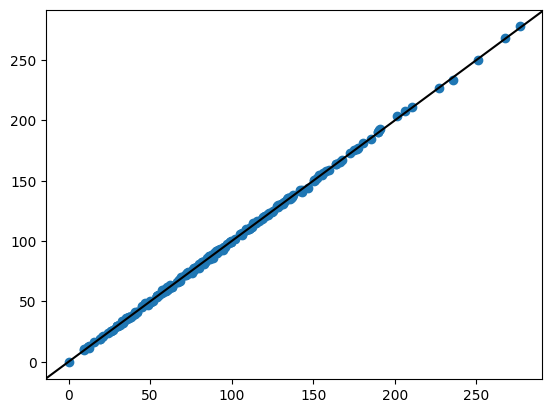

In [65]:
plt.scatter(y_valid_cur[:, 0], averaged_targets_test[:,0])
plt.axline((0,0), slope = 1, c= "black")
plt.show()
plt.scatter(y_valid_cur[:,1], averaged_targets_test[:, 1])
plt.axline((0,0), slope = 1, c= "black")
plt.show()

In [66]:
initial_ensembles.shape

(282, 1131)

In [67]:
np.cov(y_train.T)

array([[ 2.00883439, -0.73234091],
       [-0.73234091,  1.65672997]])

In [68]:
cov_part = initial_ensembles[:, -6:-2]
cov_part = cov_part.mean(0)
# variances = tf.math.softplus(cov_part[:2]).numpy()
variances = cov_part[:2]
covariances = cov_part[2:]
base_cov = np.identity(target_dim)
base_cov[0,0] = variances[0]
base_cov[1,1] = variances[1]
base_cov[0,1] = covariances[0]
base_cov[1,0] = covariances[1]
    
variances1 = tf.math.softplus(initial_ensembles[:, -2:]).numpy()
variances1 = variances1.mean(0)
base_variances = np.identity(target_dim)
base_variances[0,0] = variances1[0]
base_variances[1,1] = variances1[1]
    
final = np.linalg.cholesky(base_cov@base_cov.T + base_variances)
cov_mat = final@final.T
cov_mat_final = cov_mat

In [69]:
cov_mat_final

array([[0.55378164, 0.00655497],
       [0.00655497, 1.24317458]])

In [70]:
# np.linalg.inv(cov_mat_final)